In [1]:
import os
import json
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = {}

### Run Criteria

In [3]:
datasets = {"AIDA",
            "cweb",
            "reddit-comments",
            "reddit-posts",
            "shadowlinks-shadow",
            "shadowlinks-tail",
            "shadowlinks-top",
            "tweeki",
            "wned-wiki"}

results_folder_path = "OpenAI/gpt-5-mini-2025-08-07"
req_dates = [] # Leave empty to include all dates
run_criteria = {"overview_save_path": "Results/Multi-Evaluate-Overview/finals_gpt-overview.txt"}

#run_criteria = {"overview_save_path": ["./Results/Multi-Evaluate-Overview/spans_per_prompt-overview.txt", "./Results/Multi-Evaluate-Overview/finals-overview.txt"], "spans_per_prompt": 5} # Finals

group_by = "spans_per_prompt" # Parameter to group results by
extract_info = "overall_acc"  # Value to be extracted and averaged
split = "test"

extract_detailed_info = True
max_runs_per_dataset = 0  # Set to 0 to include all runs

### Identify revelant runs

In [4]:
def read_predictions_file(data, dataset, group_by_value, det_file_path):
    with open(det_file_path, "r") as f:
        lines = f.readlines()

    total_lines = 0                 # Total number of spans
    llm_lines = 0                   # Spans predicted by the LLM
    de_only_lines = 0               # Spans only predicted by the DE
    de_correct = 0                  # Number of correct predictions by the DE
    de_wrong = 0                    # Number of wrong predictions by the DE
    de_correct_no_llm = 0           # DE correct, no LLM prediction
    de_wrong_no_llm = 0             # DE wrong, no LLM prediction
    de_correct_llm_pred = 0         # DE correct, LLM prediction
    de_wrong_llm_pred = 0           # DE wrong, LLM prediction

    llm_correct = 0                 # Number of correct predictions by the LLM
    llm_wrong = 0                   # Number of wrong predictions by the LLM
    de_correct_llm_wrong = 0        # DE correct, LLM wrong
    de_correct_llm_correct = 0      # DE correct, LLM correct
    de_wrong_llm_correct = 0        # DE wrong, LLM correct
    de_wrong_llm_wrong = 0          # DE wrong, LLM wrong
    llm_gold_in_top_k = 0           # Number of times the gold entity is in the DE's top-k predictions and the LLM made a prediction
    llm_wrong_gold_in_top_k = 0     # Number of times the gold entity is in the DE's top-k predictions and the LLM made a wrong prediction
    llm_avg_top_k_used = []         # List of top-k values used when the LLM made a prediction - will be averaged later
    llm_wrong_avg_top_k_used = []   # List of top-k values used when the LLM made a wrong prediction - will be averaged later
    
    for line in lines:
        if not (line.startswith('"') and "---" in line):    # Only read valid prediction lines
            continue

        total_lines += 1
        parts = line.split('---')

        gold = parts[0].split('/')[1].strip()
        de_pred = parts[1].strip()
        llm_pred = parts[2].strip()
        top_k = parts[3].strip()

        if de_pred == gold:
            de_correct += 1
            if llm_pred == "N/A":
                de_correct_no_llm += 1
            else:
                de_correct_llm_pred += 1
        else:
            de_wrong += 1
            if llm_pred == "N/A":
                de_wrong_no_llm += 1
            else:
                de_wrong_llm_pred += 1

        if llm_pred != "N/A":
            llm_lines += 1

            if llm_pred == gold:
                llm_correct += 1
            else:
                llm_wrong += 1
            
            if de_pred == gold and llm_pred == gold:
                de_correct_llm_correct += 1
            elif de_pred == gold and llm_pred != gold:
                de_correct_llm_wrong += 1
            elif de_pred != gold and llm_pred == gold:
                de_wrong_llm_correct += 1
            else:
                de_wrong_llm_wrong += 1

            if f"'{gold}'" in top_k:
                llm_gold_in_top_k += 1
                if llm_pred != gold:
                    llm_wrong_gold_in_top_k += 1
            
            top_k_used = int(parts[7].strip())
            llm_avg_top_k_used.append(top_k_used)
            if llm_pred != gold:
                llm_wrong_avg_top_k_used.append(top_k_used)
        else:
            de_only_lines += 1

    data[dataset][group_by_value]["total_lines"].append(total_lines)
    data[dataset][group_by_value]["llm_lines"].append(llm_lines)
    data[dataset][group_by_value]["de_only_lines"].append(de_only_lines)
    data[dataset][group_by_value]["de_correct"].append(de_correct)
    data[dataset][group_by_value]["de_wrong"].append(de_wrong)
    data[dataset][group_by_value]["de_correct_no_llm"].append(de_correct_no_llm)
    data[dataset][group_by_value]["de_wrong_no_llm"].append(de_wrong_no_llm)
    data[dataset][group_by_value]["de_correct_llm_pred"].append(de_correct_llm_pred)
    data[dataset][group_by_value]["de_wrong_llm_pred"].append(de_wrong_llm_pred)
    data[dataset][group_by_value]["llm_correct"].append(llm_correct)
    data[dataset][group_by_value]["llm_wrong"].append(llm_wrong)
    data[dataset][group_by_value]["de_correct_llm_wrong"].append(de_correct_llm_wrong)
    data[dataset][group_by_value]["de_correct_llm_correct"].append(de_correct_llm_correct)
    data[dataset][group_by_value]["de_wrong_llm_correct"].append(de_wrong_llm_correct)
    data[dataset][group_by_value]["de_wrong_llm_wrong"].append(de_wrong_llm_wrong)
    data[dataset][group_by_value]["llm_gold_in_top_k"].append(llm_gold_in_top_k)
    data[dataset][group_by_value]["llm_gold_not_in_top_k"].append(llm_lines - llm_gold_in_top_k)
    data[dataset][group_by_value]["llm_wrong_gold_in_top_k"].append(llm_wrong_gold_in_top_k)
    data[dataset][group_by_value]["llm_avg_top_k_used"].append(np.mean(llm_avg_top_k_used) if llm_avg_top_k_used else 0)
    data[dataset][group_by_value]["llm_wrong_avg_top_k_used"].append(np.mean(llm_wrong_avg_top_k_used) if llm_wrong_avg_top_k_used else 0)



    
    

In [5]:
def read_run_predictions(data, dataset, results_folder_path, subfolder, split, group_by_value, extract_detailed_info):
    file_path = os.path.join("Results", dataset, results_folder_path, subfolder, f"predictions_{split}_statistics.txt")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    # Read File line by line
    with open(file_path, 'r') as f:
        try:
            # Read last line
            summary_line = f.readlines()[-1]
            
            parts = summary_line.split("\t", 1)[1].strip().split(" / ")
            llm_acc = float(parts[0].split(" ")[0].strip()[:-1])
            llm_acc_max = float(parts[0].split(" ")[2].strip()[1:-1])
            de_acc_hard = float(parts[1].split(" ")[0].strip()[:-1])
            llm_plus_none_acc = float(parts[2].split(" ")[0].strip()[:-1])
            overall_acc = float(parts[3].split(" ")[0].strip()[:-1])
            overall_acc_max = float(parts[3].split(" ")[2].strip()[1:-1])
            de_only_acc = float(parts[4].split(" ")[0].strip()[:-1])

            input_tokens = int(parts[4].split(" | ")[1].split(" ")[1].strip())
            output_tokens = int(parts[4].split(" | ")[1].split(" ")[4].strip())
            tokens = input_tokens + output_tokens

            spans_prompted = int(parts[4].split(" | ")[2].split(" ")[0].strip())
            spans_number = int(parts[5].split(" ")[0].strip())
            spans_prompted_percentage = float(parts[5].split(" ")[3].strip()[1:-2])

            execution_time_str = str(parts[5].split(" | ")[1].strip())
            # Convert execution time in fromat h:mm:ss.xxxxxx to seconds
            h, m, s = execution_time_str.split(":")
            execution_time = int(h) * 3600 + int(m) * 60 + float(s)

            prompt_version = str(parts[5].split(" | ")[2].strip())

            data[dataset][group_by_value]["llm_acc"].append(llm_acc)
            data[dataset][group_by_value]["llm_acc_max"].append(llm_acc_max)
            data[dataset][group_by_value]["de_acc_hard"].append(de_acc_hard)
            data[dataset][group_by_value]["llm_plus_none_acc"].append(llm_plus_none_acc)
            data[dataset][group_by_value]["overall_acc"].append(overall_acc)
            data[dataset][group_by_value]["overall_acc_max"].append(overall_acc_max)
            data[dataset][group_by_value]["de_only_acc"].append(de_only_acc)
            data[dataset][group_by_value]["input_tokens"].append(input_tokens)
            data[dataset][group_by_value]["output_tokens"].append(output_tokens)
            data[dataset][group_by_value]["tokens"].append(tokens)
            data[dataset][group_by_value]["spans_prompted"].append(spans_prompted)
            data[dataset][group_by_value]["spans_number"].append(spans_number)
            data[dataset][group_by_value]["spans_prompted_percentage"].append(spans_prompted_percentage)
            data[dataset][group_by_value]["execution_time"].append(execution_time)
            data[dataset][group_by_value]["prompt_version"].append(prompt_version)

            if extract_detailed_info:
                det_file_path = os.path.join(os.path.dirname(file_path), f"predictions_{split}.txt")
                if not os.path.exists(det_file_path):
                    print(f"Predictions File not found: {det_file_path}")
                    return
                print("Reading detailed predictions from:", det_file_path)
                read_predictions_file(data, dataset, group_by_value, det_file_path)
        except:
            pass

In [6]:
for dataset in datasets:
    if not dataset in data:
        data[dataset] = {}

    # Get names of all Subfolders in dataset folder (Results/<dataset>/<results_folder_path>/)
    subfolders = [f.name for f in os.scandir(f"Results/{dataset}/{results_folder_path}/") if f.is_dir()]
    
    found_in_dataset = 0
    for subfolder in subfolders:
        # Break if maximum runs found in dataset
        if max_runs_per_dataset > 0 and found_in_dataset >= max_runs_per_dataset:
            break
        # Check if subfolder timestamp contains a valid date
        valid = False
        if len(req_dates) == 0:
            valid = True
        for req_date in req_dates:
            if req_date in subfolder:
                valid = True
                break
        if not valid:
            continue

        # Check if run meets criteria
        try:
            run_args = json.load(open(f"Results/{dataset}/{results_folder_path}/{subfolder}/run_parameters.json", "r"))
        except FileNotFoundError:
            continue
        
        valid = True
        for key, value in run_criteria.items():
            if key not in run_args or (run_args[key] != value and not (isinstance(value, list) and run_args[key] in value)):
                valid = False
                break

        if not valid:
            continue

        print(f"Valid file found: {dataset} / {subfolder}")

        group_by_value = run_args.get(group_by)
        if not group_by_value in data[dataset]:
            data[dataset][group_by_value] = {"llm_acc": [],
                                            "llm_acc_max": [],
                                            "de_acc_hard": [],
                                            "llm_plus_none_acc": [],
                                            "overall_acc": [],
                                            "overall_acc_max": [],
                                            "de_only_acc": [],
                                            "input_tokens": [],
                                            "output_tokens": [],
                                            "tokens": [],
                                            "spans_prompted": [],
                                            "spans_number": [],
                                            "spans_prompted_percentage": [],
                                            "execution_time": [],
                                            "prompt_version": [],
                                            "total_lines": [],
                                            "llm_lines": [],
                                            "de_only_lines": [],
                                            "de_correct": [],
                                            "de_wrong": [],
                                            "de_correct_no_llm": [],
                                            "de_wrong_no_llm": [],
                                            "de_correct_llm_pred": [],
                                            "de_wrong_llm_pred": [],
                                            "llm_correct": [],
                                            "llm_wrong": [],
                                            "de_correct_llm_wrong": [],
                                            "de_correct_llm_correct": [],
                                            "de_wrong_llm_correct": [],
                                            "de_wrong_llm_wrong": [],
                                            "llm_gold_in_top_k": [],
                                            "llm_gold_not_in_top_k": [],
                                            "llm_wrong_gold_in_top_k": [],
                                            "llm_avg_top_k_used": [],
                                            "llm_wrong_avg_top_k_used": []}

        # Read Run results
        read_run_predictions(data, dataset, results_folder_path, subfolder, split, group_by_value, extract_detailed_info)
        found_in_dataset += 1



Valid file found: AIDA / 2025-12-22_12-40-24
Reading detailed predictions from: Results/AIDA/OpenAI/gpt-5-mini-2025-08-07/2025-12-22_12-40-24/predictions_test.txt
Valid file found: AIDA / 2025-12-22_12-49-01
Reading detailed predictions from: Results/AIDA/OpenAI/gpt-5-mini-2025-08-07/2025-12-22_12-49-01/predictions_test.txt
Valid file found: cweb / 2025-12-24_02-31-09
Reading detailed predictions from: Results/cweb/OpenAI/gpt-5-mini-2025-08-07/2025-12-24_02-31-09/predictions_test.txt
Valid file found: tweeki / 2025-12-22_13-00-03
Reading detailed predictions from: Results/tweeki/OpenAI/gpt-5-mini-2025-08-07/2025-12-22_13-00-03/predictions_test.txt
Valid file found: tweeki / 2025-12-22_13-14-16
Reading detailed predictions from: Results/tweeki/OpenAI/gpt-5-mini-2025-08-07/2025-12-22_13-14-16/predictions_test.txt
Valid file found: wned-wiki / 2025-12-23_15-51-13
Reading detailed predictions from: Results/wned-wiki/OpenAI/gpt-5-mini-2025-08-07/2025-12-23_15-51-13/predictions_test.txt
Vali

In [7]:
data

{'AIDA': {5: {'llm_acc': [61.08, 60.11],
   'llm_acc_max': [79.57, 79.57],
   'de_acc_hard': [40.11, 40.11],
   'llm_plus_none_acc': [68.65, 67.78],
   'overall_acc': [84.5, 84.3],
   'overall_acc_max': [88.32, 88.32],
   'de_only_acc': [80.18, 80.18],
   'input_tokens': [683907, 682760],
   'output_tokens': [61751, 154227],
   'tokens': [745658, 836987],
   'spans_prompted': [925, 925],
   'spans_number': [4485, 4485],
   'spans_prompted_percentage': [20.62, 20.62],
   'execution_time': [160.545425, 304.540792],
   'prompt_version': ['v3', 'v3'],
   'total_lines': [4485, 4485],
   'llm_lines': [925, 925],
   'de_only_lines': [3560, 3560],
   'de_correct': [3596, 3596],
   'de_wrong': [889, 889],
   'de_correct_no_llm': [3225, 3225],
   'de_wrong_no_llm': [335, 335],
   'de_correct_llm_pred': [371, 371],
   'de_wrong_llm_pred': [554, 554],
   'llm_correct': [565, 556],
   'llm_wrong': [360, 369],
   'de_correct_llm_wrong': [61, 63],
   'de_correct_llm_correct': [310, 308],
   'de_wrong

### Plot value

AIDA {5: {'llm_acc': [61.08, 60.11], 'llm_acc_max': [79.57, 79.57], 'de_acc_hard': [40.11, 40.11], 'llm_plus_none_acc': [68.65, 67.78], 'overall_acc': [84.5, 84.3], 'overall_acc_max': [88.32, 88.32], 'de_only_acc': [80.18, 80.18], 'input_tokens': [683907, 682760], 'output_tokens': [61751, 154227], 'tokens': [745658, 836987], 'spans_prompted': [925, 925], 'spans_number': [4485, 4485], 'spans_prompted_percentage': [20.62, 20.62], 'execution_time': [160.545425, 304.540792], 'prompt_version': ['v3', 'v3'], 'total_lines': [4485, 4485], 'llm_lines': [925, 925], 'de_only_lines': [3560, 3560], 'de_correct': [3596, 3596], 'de_wrong': [889, 889], 'de_correct_no_llm': [3225, 3225], 'de_wrong_no_llm': [335, 335], 'de_correct_llm_pred': [371, 371], 'de_wrong_llm_pred': [554, 554], 'llm_correct': [565, 556], 'llm_wrong': [360, 369], 'de_correct_llm_wrong': [61, 63], 'de_correct_llm_correct': [310, 308], 'de_wrong_llm_correct': [255, 248], 'de_wrong_llm_wrong': [299, 306], 'llm_gold_in_top_k': [736, 

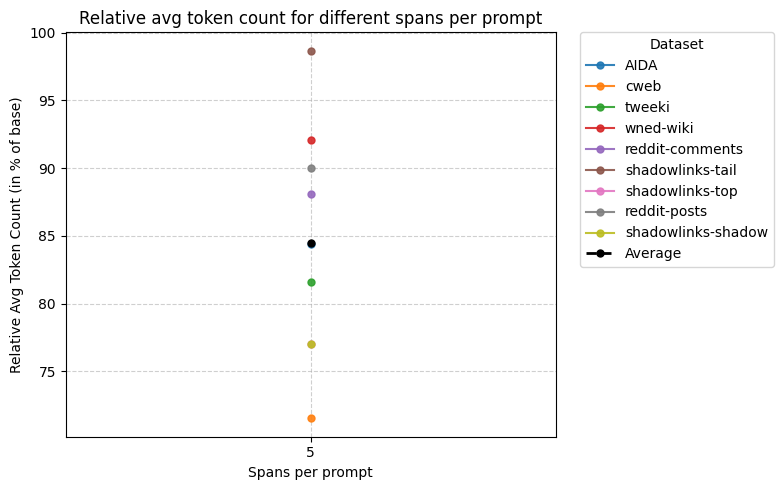

In [8]:
sort = True
in_reverse = False

relative = False
base_value = "llm_lines" # Number or str of extracted value (e.g., "total_lines", "llm_lines")

do_overall_average = True

avg_data = {}
# --- Plot ---
plt.figure(figsize=(8, 5))

# Create a color palette for datasets
colors = plt.cm.tab10.colors
color_map = {dataset: colors[i % len(colors)] for i, dataset in enumerate(data.keys())}

# Plot per-dataset average accuracies
for dataset, results in data.items():
    print(dataset, results)
    if sort:
        results = dict(sorted(results.items(), key=lambda item: float(item[0]), reverse=in_reverse))
    params = list(results.keys())
    values = [round(np.mean(r[extract_info]), 2) for r in results.values()]

    if relative:
        # If base value is of type int:
        if isinstance(base_value, int):
            base_value_here = values[base_value]
        elif isinstance(base_value, str):
            base_value_here = [round(np.mean(r[base_value]), 2) for r in results.values()]

        if isinstance(base_value_here, list):
            values = [round((v / base_value_here[i]) * 100, 2) for i, v in enumerate(values)]
        else:   
            values = [round((v / base_value_here) * 100, 2) for v in values]

    avg_data[dataset] = dict(zip(params, values))

    base_color = color_map[dataset]

    # Main (primary) accuracy
    plt.plot(params, values, marker="o", label=dataset, color=base_color, alpha=0.9, markersize=5)

# Plot overall average accuracy (thicker dashed line)
if do_overall_average:
    avg_values = [round(np.mean([avg_data[ds][param] for ds in avg_data]), 2) for param in list(next(iter(avg_data.values())).keys())]

    plt.plot(
        list(avg_data[list(avg_data.keys())[0]].keys()),
        avg_values,
        marker="o",
        color="black",
        markersize=5,
        linewidth=2,
        linestyle="--",
        label="Average",
    )


# Aesthetics
plt.xticks(params)

plt.title(f"Relative avg token count for different spans per prompt")
plt.xlabel(f"Spans per prompt")
plt.ylabel(f"Relative Avg Token Count (in % of base)")
plt.grid(True, linestyle="--", alpha=0.6)

# Legend outside the plot
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()


In [9]:
avg_data

{'AIDA': {5: 84.4},
 'cweb': {5: 71.54},
 'tweeki': {5: 81.6},
 'wned-wiki': {5: 92.08},
 'reddit-comments': {5: 88.07},
 'shadowlinks-tail': {5: 98.67},
 'shadowlinks-top': {5: 77.04},
 'reddit-posts': {5: 90.04},
 'shadowlinks-shadow': {5: 76.99}}

In [10]:
avg_values

[84.49]

### Calculate average values for each collected data

In [11]:
avg_data = {}
for dataset in data:
    avg_data[dataset] = {}
    for group_by_value in data[dataset]:
        avg_data[dataset][group_by_value] = {}
        for param in data[dataset][group_by_value]:
            values = data[dataset][group_by_value][param]
            if isinstance(values[0], str):
                avg_data[dataset][group_by_value][param] = values[0]
            else:
                avg_data[dataset][group_by_value][param] = round(np.mean(values), 2)

avg_data

{'AIDA': {5: {'llm_acc': 60.6,
   'llm_acc_max': 79.57,
   'de_acc_hard': 40.11,
   'llm_plus_none_acc': 68.22,
   'overall_acc': 84.4,
   'overall_acc_max': 88.32,
   'de_only_acc': 80.18,
   'input_tokens': 683333.5,
   'output_tokens': 107989.0,
   'tokens': 791322.5,
   'spans_prompted': 925.0,
   'spans_number': 4485.0,
   'spans_prompted_percentage': 20.62,
   'execution_time': 232.54,
   'prompt_version': 'v3',
   'total_lines': 4485.0,
   'llm_lines': 925.0,
   'de_only_lines': 3560.0,
   'de_correct': 3596.0,
   'de_wrong': 889.0,
   'de_correct_no_llm': 3225.0,
   'de_wrong_no_llm': 335.0,
   'de_correct_llm_pred': 371.0,
   'de_wrong_llm_pred': 554.0,
   'llm_correct': 560.5,
   'llm_wrong': 364.5,
   'de_correct_llm_wrong': 62.0,
   'de_correct_llm_correct': 309.0,
   'de_wrong_llm_correct': 251.5,
   'de_wrong_llm_wrong': 302.5,
   'llm_gold_in_top_k': 736.0,
   'llm_gold_not_in_top_k': 189.0,
   'llm_wrong_gold_in_top_k': 175.5,
   'llm_avg_top_k_used': 10.0,
   'llm_wron

Search for value

In [12]:
searched_value = "overall_acc_max"

relative = ""  # Empty or value to calculate relative percentages against

searched = {}
for dataset in data:
    searched[dataset] = {}
    for group_by_value in data[dataset]:
        values = data[dataset][group_by_value][searched_value]
        if relative != "":
            base_values = data[dataset][group_by_value][relative]
            values = [round((v / base_values[i]) * 100, 2) for i, v in enumerate(values)]
        
        searched[dataset][group_by_value] = round(np.mean(values), 2)

searched

{'AIDA': {5: 88.32},
 'cweb': {5: 78.16},
 'tweeki': {5: 84.7},
 'wned-wiki': {5: 94.86},
 'reddit-comments': {5: 92.94},
 'shadowlinks-tail': {5: 99.0},
 'shadowlinks-top': {5: 80.2},
 'reddit-posts': {5: 95.02},
 'shadowlinks-shadow': {5: 82.3}}